# Ground State Property Calculations of H2, LiH and O2 using IBM Qiskit’s Quantum Simulator

### Import of nessesary libraries, defenition of molecules and methods

In [ ]:
# Importing everithing nessesary for the project

# Pathon basics
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Qiskit 
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP              
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import EstimatorV2 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2   # ?????
from qiskit import transpile 

# Qiskit Nature
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

In [ ]:
# Define all molecules and their parameters

# Define dataclass for molecule configuration
@dataclass
class Molecule:
    name: str
    unit: DistanceUnit
    bond_precise: float
    experimental_grStEn: float
    bond_min: float
    bond_max: float
    step: float
    atom1: str
    atom2: str
    active_electrons: int 
    spatial_orbitals: int
    bond_grid: list = None  # To be filled later with generated bond lengths

# Information about molecule geometry that will be used later 
H2 = Molecule(
    name="H2",
    unit=DistanceUnit.ANGSTROM,
    bond_precise=0.74,
    experimental_grStEn = -1.136,
    bond_min=0.5,
    bond_max=4.0,
    step=0.05,
    atom1="H",
    atom2="H",
    active_electrons = 2,           
    spatial_orbitals = 2,   
    bond_grid = [0.65, 0.75, 0.85, 1.0, 1.75, 2.5]   # Manually defined grid for H2 molecule
)

LiH = Molecule(
    name="LiH",
    unit=DistanceUnit.ANGSTROM,
    bond_precise=1.595,
    experimental_grStEn = -7.98055,                
    bond_min=0.5,
    bond_max=4.0,
    step=0.05,
    atom1="Li",
    atom2="H",
    active_electrons = 2,           
    spatial_orbitals = 2,
    bond_grid = [0.8, 1.4, 1.5, 1.6, 2.2, 3.0, 3.5]   # Manually defined grid for LiH molecule           
)

O2 = Molecule(
    name="O2",
    unit=DistanceUnit.ANGSTROM,
    bond_precise=1.21,
    experimental_grStEn = -149.9,     
    bond_min=0.5,
    bond_max=4.0,
    step=0.05,
    atom1="O",
    atom2="O",
    active_electrons = 4,            # This is rought simiplification, but nessesary,
    spatial_orbitals = 4,            # so it is possible to run calculations
    bond_grid = [0.8, 1.1, 1.2, 1.3, 2.0, 3.0]   # Manually defined grid for O2 molecule
)

# Dictionary of molecules for easy access
molecules = {
    "H2": H2,
    "LiH": LiH,
    "O2": O2,
}


In [ ]:
# Method we used in one object

class Methods:
    driver: type = PySCFDriver
    basis: str = "sto6g"
    transformer: type = ActiveSpaceTransformer
    mapper: type = JordanWignerMapper
    initial_state_method: type = HartreeFock
    ansatz_method: type = UCCSD
    classical_method: type = NumPyMinimumEigensolver
    optimizer_method: type = SLSQP(maxiter=10)
    quantum_method: type = VQE
    reps: int = 1
    estimator: object = StatevectorEstimator()
    service: object = None  # Placeholder for IBM Quantum Runtime Service
    backend: str = None # Placeholder for IBM Fake Quantum backend
    options: object = None  # Placeholder for Estimator options

#Define methods for simulation without noise
methodsPreciseSimulation = Methods()

# Define methods for simulation with noise (FakeMelbourneV2 backend)
methodsFakeBackendSimulation = Methods()
methodsFakeBackendSimulation.service = QiskitRuntimeService()
methodsFakeBackendSimulation.backend = FakeMelbourneV2()
methodsFakeBackendSimulation.backend.refresh(methodsFakeBackendSimulation.service)
methodsFakeBackendSimulation.options = EstimatorOptions()
methodsFakeBackendSimulation.options.default_shots = 100
methodsFakeBackendSimulation.estimator = EstimatorV2(methodsFakeBackendSimulation.backend, 
                                                      options = methodsFakeBackendSimulation.options)

qiskit_runtime_service.__init__:WARNING:2025-12-24 08:46:57,977: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
fake_backend.refresh:WARNING:2025-12-24 08:46:58,168: The refreshing of fake_melbourne has failed: list index out of range
qiskit_runtime_service.__init__:WARNING:2025-12-24 08:47:01,425: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account wi

### VQE Pipeline Implementation

In [6]:
# Function to generate bond length grid (all bond lengthes in list)
def generate_bond_grid(molecule: Molecule):
    bond_grid_auto = np.arange(molecule.bond_min, molecule.bond_max, molecule.step)
    return bond_grid_auto

In [ ]:
# Function to get ESP and energy shift from driver
def getESPfromDriver(method: Methods, molecule: Molecule, atomStr):
    driver = method.driver(
        atom = atomStr,  
        basis = method.basis,    
        charge = 0,
        spin = 0,
        unit = DistanceUnit.ANGSTROM,
    )

    transformer = method.transformer(
    num_electrons=molecule.active_electrons,
    num_spatial_orbitals=molecule.spatial_orbitals
    )

    ESP = driver.run()
    print("Full Energy HF: ", ESP.reference_energy)
    ESP = transformer.transform(ESP)
    print("Active Energy HF: ", ESP.reference_energy)
    print(ESP.hamiltonian.constants['ActiveSpaceTransformer'])
   
    energy_shift = ESP.hamiltonian.constants['ActiveSpaceTransformer']
   
    return ESP, energy_shift


In [ ]:
# Function to map hamiltonian to qubit gates
def hamiltonianToGates(method: Methods, ESP):
    # map hamiltonian to the qubit states using the mapper
    second_quantization_operators = ESP.second_q_ops()
    hamiltonian_phys = second_quantization_operators[0]
    qubit_hamiltonian = method.mapper().map(second_q_ops=hamiltonian_phys)
    return qubit_hamiltonian

In [9]:
# This function puts everithing together and found ground state energy for given conditions QC
def findEigenvalueQC(ESP, qubit_hamiltonian, energy_shift, methods: Methods):
    initial_state = methods.initial_state_method(
        ESP.num_spatial_orbitals,
        ESP.num_particles,
        methods.mapper() 
    )

    ansatz = methods.ansatz_method(
        ESP.num_spatial_orbitals,
        ESP.num_particles,
        methods.mapper(),
        reps = methods.reps,
        initial_state = initial_state
    )

    if methods.backend is not None:
        ansatz = transpile(ansatz, backend=methods.backend, optimization_level=1)
        print("Transpiled ansatz for backend:", methods.backend.backend_name)

    solverQC = methods.quantum_method(methods.estimator, ansatz, methods.optimizer_method)
    solverQC.initial_point = [0.0] * ansatz.num_parameters
    try: 
        resultQC = solverQC.compute_minimum_eigenvalue(qubit_hamiltonian)
        electronicEnergyQC = resultQC.eigenvalue
        grStEnQC = electronicEnergyQC + ESP.nuclear_repulsion_energy
        grStEnQC = grStEnQC + energy_shift
        grStEnQC = grStEnQC.real
    except Exception as e:
        print("Error:", e)
        grStEnQC = None

    return grStEnQC  

# This function puts everithing together and found ground state energy for given conditions CC
def findEigenvalueCC(ESP, qubit_hamiltonian, energy_shift, solverCC):
    try:
        resultCC = solverCC().compute_minimum_eigenvalue(qubit_hamiltonian)
        electronicEnergyCC = resultCC.eigenvalue
        grStEnCC = electronicEnergyCC + ESP.nuclear_repulsion_energy
        grStEnCC = grStEnCC + energy_shift
        grStEnCC = grStEnCC.real
    except Exception as e:
        print("Error:", e)
        grStEnCC = None

    return grStEnCC

In [ ]:
# Final function that runs everithing for given molecule
# And find ground state energy for given bond length

def moleculeGeometrySingleRun(molecule: Molecule, methods: Methods, bond_length: float, doCC: bool, doQC: bool):
    start = 0
    end = 0
    runtimeCC = 0
    runtimeQC = 0

    atomStr = molecule.atom1 + " 0 0 0; " + molecule.atom2 + " 0 0 " + str(bond_length)
    moleculeESP, energy_shift = getESPfromDriver(methods, molecule, atomStr)

    print("Go to Hamiltonian")
    qubit_hamiltonian = hamiltonianToGates(methods, moleculeESP)
    print("Got Hamiltonian")

    if doCC:
        print("Go to ground state Classical solver")
        start = time.time()
        grStEnCC = findEigenvalueCC(moleculeESP, qubit_hamiltonian, energy_shift, methods.classical_method)
        print("Got ground state Classical solver")
        end = time.time()
        runtimeCC = abs(end - start)
        print("Classical Runtime is: ", runtimeCC)
    else :
        grStEnCC = None    # Classical computation not performed
        runtimeCC = None   # Classical computation not performed
    
    if doQC:
        print("Go to ground state Quantum solver")
        start = time.time()
        grStEnQC = findEigenvalueQC(moleculeESP, qubit_hamiltonian, energy_shift, methods)
        print("Got ground state Quantum solver")
        end = time.time()
        runtimeQC = abs(end - start)
        print("Quantum Runtime is: ", runtimeQC)
    else :
        grStEnQC = None    # Quantum computation not performed
        runtimeQC = None   # Quantum computation not performed

    print("Bond length: " , bond_length)
    print("Ground state energy Classical Computation" , grStEnCC)
    print("Ground state energy Quantum Computation" , grStEnQC)
    print("  ")

    return {
        "grStEn": (bond_length, grStEnCC, grStEnQC, moleculeESP.reference_energy),   # FIX ME 
        "runtime": (bond_length, runtimeCC, runtimeQC)
    }

def moleculeGeometryItterateRun(molecule: Molecule, methods: Methods, use_manual_grid: bool):
    grStEn = []
    runtime = []
    result = None
    bond_grid_gen = generate_bond_grid(molecule)
    bond_grid_gen = [round(x, 2) for x in bond_grid_gen]
    bond_grid_man = molecule.bond_grid

    if use_manual_grid == False:
        for i in bond_grid_gen:
            result = (moleculeGeometrySingleRun(molecule, methods, i, True, True))
            grStEn.append(result["grStEn"])
            runtime.append(result["runtime"])
    else:
        for i in bond_grid_gen:
            if i in bond_grid_man:
                print("QC and CC, bond length: ", i)
                result = (moleculeGeometrySingleRun(molecule, methods, i, True, True))
                grStEn.append(result["grStEn"])
                runtime.append(result["runtime"])
            else:
                print("Only CC, bond length: ", i)
                result = (moleculeGeometrySingleRun(molecule, methods, i, True, False))
                grStEn.append(result["grStEn"])
                runtime.append(result["runtime"])    

    return {
        "molecule": molecule,
        "grStEn": grStEn,
        "runtime": runtime
    }



### Data Processing and Visualization Functions

In [ ]:
# Functions used to print tables and graphs 

def printTrableEnergy(results, molecule):                  
     print(molecule.name + ": Energy vs Bond Length")
     df = pd.DataFrame(results, columns=["Bond length (Å)", 
                                         "Classical Computation - Energy (Hartree)", 
                                         "Classical simulation of Quantum Computation - Energy (Hartree)", 
                                         "HF energy Hartree"])      #    FIX MEEEE !!!!
     df_rounded = df.round(3)
     print(df_rounded)
     print("Experimental data: ", molecule.bond_precise, "Å , ", molecule.experimental_grStEn, "Hartree")

def printTrableRuntime(results, molecule):
     print(molecule.name + ": Runtime vs Bond Length")
     df = pd.DataFrame(results, columns=["Bond length (Å)", "Classical Computation - Runtime (seconds)", "Classical simulation of Quantum Computation - Runtime (seconds)"])
     df_rounded = df.round(3)
     avg_classical = df["Classical Computation - Runtime (seconds)"].mean()
     avg_quantum_sim = df["Classical simulation of Quantum Computation - Runtime (seconds)"].mean()
     print(df_rounded)
     print("Average Classical Computation Runtime: ", round(avg_classical, 3), "seconds")
     print("Average Classical simulation of Quantum Computation Runtime: ", round(avg_quantum_sim, 3), "seconds")

def plotResultsEnergy(results, molecule):
    bond_lengths = [r[0] for r in results]
    classical = [r[1] for r in results]
    quantum = [r[2] for r in results]
    hf = [r[3] for r in results]
    plt.title(molecule.name + ": Energy vs Bond Length", fontsize=16, fontweight='bold')
    plt.plot(bond_lengths, classical, label="Classical Computation")
    plt.scatter(bond_lengths, quantum, label="Classical simulation of Quantum Computation", color='orange')
    plt.plot(bond_lengths, hf, label="HF energy", color='green')     ### FIX ME   !!!!!
    plt.scatter([molecule.bond_precise], [molecule.experimental_grStEn], color='red', label='Experimental')
    plt.xlabel("Bond length (Å)")
    plt.ylabel("Energy (Hartree)")
    plt.legend()
    plt.show()

def plotResultsRuntime(results, molecule):
    bond_lengths = [r[0] for r in results]
    classical = [r[1] for r in results]
    quantum = [r[2] for r in results]
    # avg_classical = sum(classical) / len(classical)
    # avg_quantum = sum(quantum) / len(quantum)
    plt.title(molecule.name + ": Runtime vs Bond Length", fontsize=16, fontweight='bold')
    plt.scatter(bond_lengths, classical, label="Classical Computation", color='blue')
    plt.scatter(bond_lengths, quantum, label="Classical simulation of Quantum Computation", color='orange')
    # plt.axhline(avg_classical, color='blue', linestyle='--', alpha=0.4, label="Average Classical Computation")
    # plt.axhline(avg_quantum, color='orange', linestyle='--', alpha=0.4, label="Average Classical simulation of Quantum Computation")
    plt.xlabel("Bond length (Å)")
    plt.ylabel("Runtime (seconds)")
    plt.legend()
    plt.show()

def getAllData(resultsEnergy, resultsRuntime, molecule):
     printTrableEnergy(resultsEnergy, molecule)
     printTrableRuntime(resultsRuntime, molecule)
     plotResultsEnergy(resultsEnergy, molecule)
     plotResultsRuntime(resultsRuntime, molecule)

### Running calculation

##### H2 calculation - noiseless

Only CC, bond length:  0.5
Full Energy HF:  -1.053187938674564
Active Energy HF:  -1.053187938674564
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.006532192230224609
Bond length:  0.5
Ground state energy Classical Computation -1.0653851727714778
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.55
Full Energy HF:  -1.088737941438584
Active Energy HF:  -1.088737941438584
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.005302906036376953
Bond length:  0.55
Ground state energy Classical Computation -1.1023601927582898
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.6
Full Energy HF:  -1.110396230751277
Active Energy HF:  -1.110396230751277
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.00

/home/ari/qk-env/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/ari/qk-env/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


Got ground state Quantum solver
Quantum Runtime is:  0.47447919845581055
Bond length:  0.65
Ground state energy Classical Computation -1.1389081907324556
Ground state energy Quantum Computation -1.1389081906842544
  
Only CC, bond length:  0.7
Full Energy HF:  -1.126100302865754
Active Energy HF:  -1.126100302865754
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.006004810333251953
Bond length:  0.7
Ground state energy Classical Computation -1.144979079498298
Ground state energy Quantum Computation None
  
QC and CC, bond length:  0.75
Full Energy HF:  -1.1247307455368953
Active Energy HF:  -1.1247307455368953
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.00497746467590332
Go to ground state Quantum solver
Got ground state Quantum solver
Quantum Runtime is:  0.3795781135559082
Bond length:  0.75
Ground state energy C

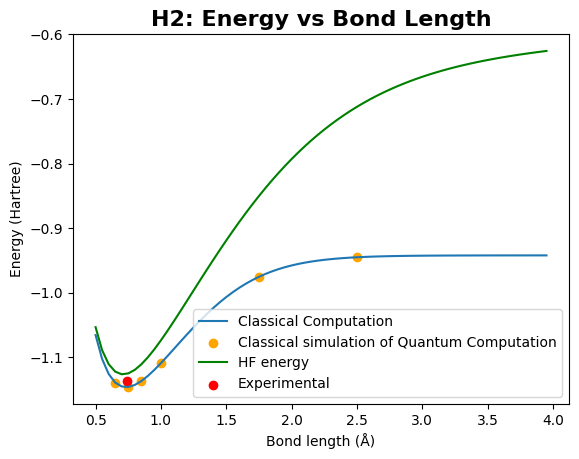

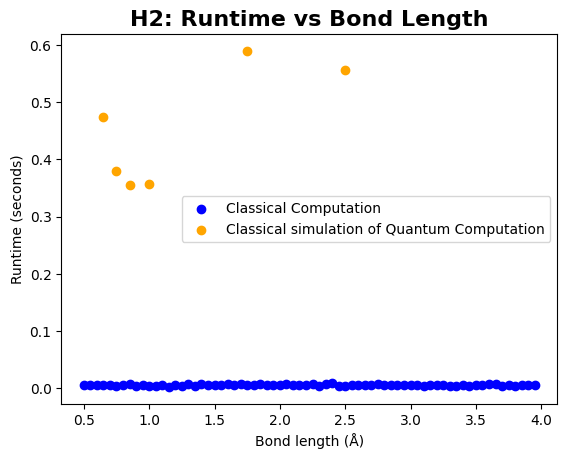

In [20]:
resultsH2precise = moleculeGeometryItterateRun(molecules["H2"], methodsPreciseSimulation, True)
getAllData(resultsH2precise["grStEn"], resultsH2precise["runtime"], resultsH2precise["molecule"])

#### H2 calculations - noisy

Only CC, bond length:  0.5
Full Energy HF:  -1.053187938674564
Active Energy HF:  -1.053187938674564
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.027796268463134766
Bond length:  0.5
Ground state energy Classical Computation -1.0653851727714787
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.55
Full Energy HF:  -1.088737941438584
Active Energy HF:  -1.088737941438584
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.006078481674194336
Bond length:  0.55
Ground state energy Classical Computation -1.1023601927582964
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.6
Full Energy HF:  -1.110396230751277
Active Energy HF:  -1.110396230751277
0.0
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.00

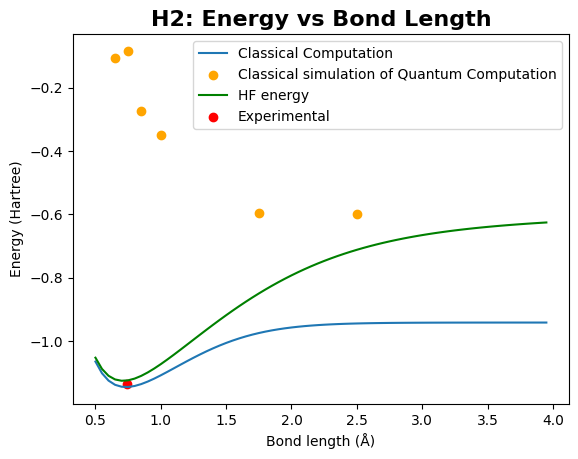

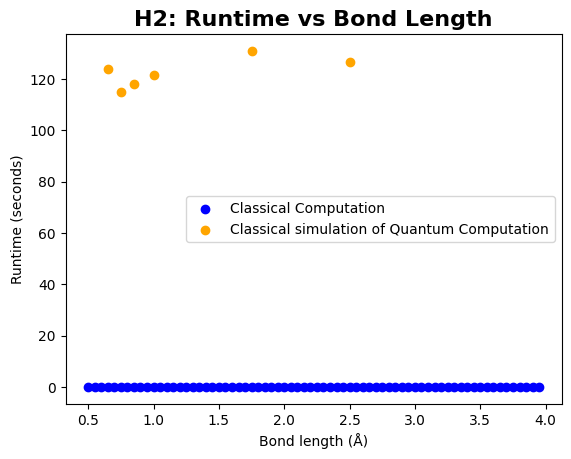

In [ ]:
resultsH2FakeMelbourne = moleculeGeometryItterateRun(molecules["H2"], methodsFakeBackendSimulation, True)
getAllData(resultsH2FakeMelbourne["grStEn"], resultsH2FakeMelbourne["runtime"], resultsH2FakeMelbourne["molecule"])

#### LiH calculation - noiseless

Only CC, bond length:  0.5
Full Energy HF:  -7.117680660455436
Active Energy HF:  -7.117680660455436
-9.318095968788104
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.010362863540649414
Bond length:  0.5
Ground state energy Classical Computation -7.118224954971171
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.55
Full Energy HF:  -7.267692526997764
Active Energy HF:  -7.267692526997764
-9.144026105278442
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.005776166915893555
Bond length:  0.55
Ground state energy Classical Computation -7.267983399762496
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.6
Full Energy HF:  -7.390914707457819
Active Energy HF:  -7.390914707457819
-8.99258218286764
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Cl

/home/ari/qk-env/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/ari/qk-env/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


Got ground state Quantum solver
Quantum Runtime is:  0.4964768886566162
Bond length:  0.8
Ground state energy Classical Computation -7.707595870083568
Ground state energy Quantum Computation -7.707594690901914
  
Only CC, bond length:  0.85
Full Energy HF:  -7.756453352003199
Active Energy HF:  -7.756453352003199
-8.473355440559942
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.0059680938720703125
Bond length:  0.85
Ground state energy Classical Computation -7.756580037114512
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.9
Full Energy HF:  -7.797113019397011
Active Energy HF:  -7.797113019397011
-8.402513129721298
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.005562782287597656
Bond length:  0.9
Ground state energy Classical Computation -7.79723473688637
Ground state energy Quantum Computation Non

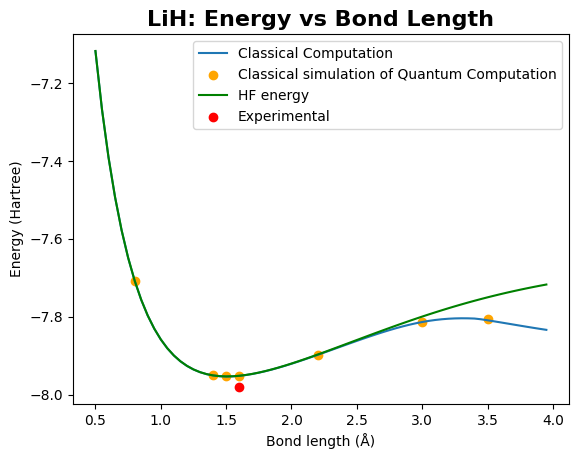

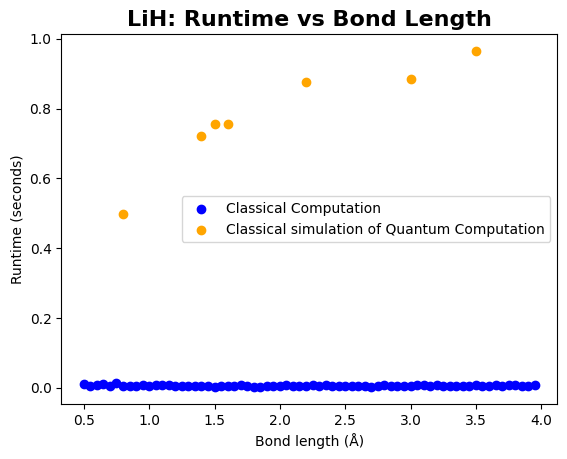

In [22]:
resultsLiHprecise = moleculeGeometryItterateRun(molecules["LiH"], methodsPreciseSimulation, True)
getAllData(resultsLiHprecise["grStEn"], resultsLiHprecise["runtime"], resultsLiHprecise["molecule"])

#### LiH calculation - noisy

Only CC, bond length:  0.5
Full Energy HF:  -7.117680660455436
Active Energy HF:  -7.117680660455436
-9.318095968788004
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.00617671012878418
Bond length:  0.5
Ground state energy Classical Computation -7.118224954971169
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.55
Full Energy HF:  -7.267692526997764
Active Energy HF:  -7.267692526997764
-9.144026105278423
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.005963563919067383
Bond length:  0.55
Ground state energy Classical Computation -7.267983399762494
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.6
Full Energy HF:  -7.390914707457819
Active Energy HF:  -7.390914707457819
-8.99258218286764
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Cla

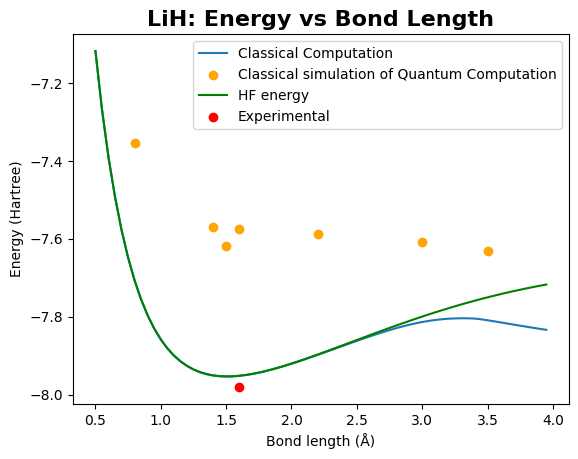

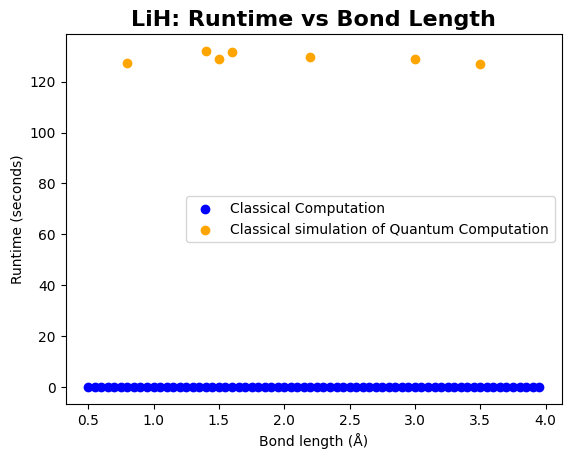

In [ ]:
resultsLiHnoisy = moleculeGeometryItterateRun(molecules["LiH"], methodsFakeBackendSimulation, True)
getAllData(resultsLiHnoisy["grStEn"], resultsLiHnoisy["runtime"], resultsLiHnoisy["molecule"])

#### O2 calculations - noiseless

In [103]:
resultmidO2 = moleculeGeometryItterateRun(molecules["O2"], methodsPreciseSimulation, True)
getAllData(resultmidO2["grStEn"], resultmidO2["runtime"], resultmidO2["molecule"])

Only CC, bond length:  0.5
Full Energy HF:  -140.26473278240906
Active Energy HF:  -140.26473278240906
-202.16968817948447
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.07129812240600586
Bond length:  0.5
Ground state energy Classical Computation -140.3776798720643
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.55
Full Energy HF:  -142.66960547242678
Active Energy HF:  -142.66960547242678
-198.40665323527088
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.018897533416748047
Bond length:  0.55
Ground state energy Classical Computation -142.76840895446125
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.6
Full Energy HF:  -144.4232592858408
Active Energy HF:  -144.4232592858408
-195.04154550508025
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground 

/home/ari/qk-env/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/ari/qk-env/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


KeyboardInterrupt: 

#### O2 calculations - noisy

In [ ]:
resultO2noisy = moleculeGeometryItterateRun(molecules["O2"], methodsFakeBackendSimulation, True)
getAllData(resultO2noisy["grStEn"], resultO2noisy["runtime"], resultO2noisy["molecule"])

Only CC, bond length:  0.5
Full Energy HF:  -140.26473278240917
Active Energy HF:  -140.26473278240917
-202.16968817948467
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  1.2777273654937744
Bond length:  0.5
Ground state energy Classical Computation -140.3776798720645
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.55
Full Energy HF:  -142.66960547242667
Active Energy HF:  -142.66960547242667
-198.40665323527077
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground state Classical solver
Classical Runtime is:  0.3089580535888672
Bond length:  0.55
Ground state energy Classical Computation -142.76840895446114
Ground state energy Quantum Computation None
  
Only CC, bond length:  0.6
Full Energy HF:  -144.42325928584086
Active Energy HF:  -144.42325928584086
-195.04154550508028
Go to Hamiltonian
Got Hamiltonian
Go to ground state Classical solver
Got ground s

NameError: name 'getAllData' is not defined